# 3.2.2.- Implementación de un Sistema de Recomendación de películas con Factorización Matricial: MovieLens


* En este Notebook vamos a implementar y evaluar un ***Sistema de Recomendación basado en Filtrado Colaborativo con Factorización Matricial*** usando la base de datos de [MovieLens 100K](https://grouplens.org/datasets/movielens/).


* Esta base de datos contiene 100.000 votos con notas de 1 a 5 de 943 usuarios sobre 1682 películas.


* Este dataset ha sido dividido en votaciones de entrenamiento (80%) y votaciones de test (20%). Además para simplificar el problema, los códigos de usuarios e items, han sido modificados para que comience en 0 y terminen en el número de (usuarios / items) - 1.


* Para ***implementar y evaluar este Sistema de Recomendación*** realizaremos los siguientes paso:
<span></span><br>
    1. [Lectura del Dataset (Entrenamiento y Test)](#M1)
<span></span><br>
    2. [Implementación: Cálculo de las Predicciones](#M2)
<span></span><br>
    3. [Implementación: PMF](#M3)
<span></span><br>
    4. [Cálculo de las recomendaciones(*)](#M4)
<span></span><br>
    5. [Evaluación del Sistema de Recomendación (MAE)](#M5)
<span></span><br>
    6. [Sistema de Recomendación y Evaluación](#M6)


##### (*): El punto del cálculo de las Recomendaciones no lo vamos a realizar ya que este punto no es relevante de cara a evaluar el sistema de recomendación implementado.


<hr>


# <a name="M1">1.- Lectura del Dataset (Entrenamiento y Test)
    
    
* A continuación implementamos una función que data la ruta donde se encuentra un fichero con la estructura "ID_USER::ID_MOVIE::RATING" nos devuelva una matriz de votos:

In [1]:
def read_ratings_matrix(file):

    ratings = [[None for _ in range(NUM_ITEMS)] for _ in range(NUM_USERS)] 
    
    with open(file, 'r') as reader:
        for line in reader:
            [u, i, rating] = line.split("::")
            ratings[int(u)][int(i)] = int(rating)
            
    return ratings

# <a name="M2">2.- Implementación: Cálculo de las Predicciones</a>
    
* A continuación se implemetan los métodos necesarios para el cáculo de las predicciones:

In [2]:
from tqdm.notebook import tqdm

# Calculo del voto medio de la base de datos
def get_avg_ratings(ratings_matrix):
    
    sum_ratings = 0
    count_ratings = 0

    for u in tqdm(range(NUM_USERS), leave=False):
        for i in range(NUM_ITEMS):
            if ratings_matrix[u][i] != None:
                sum_ratings += ratings_matrix[u][i]
                count_ratings += 1

    return sum_ratings/float(count_ratings)


# Cálculo de una predicción (con el bias)
def compute_biased_prediction (avg, b_u, b_i, p_u, q_i, num_factors):
    deviation = 0
    for k in range(num_factors):
        deviation += p_u[k] * q_i[k]
        
    prediction = avg + b_u + b_i + deviation
    return prediction


# Calculo de todas las predicciones del sistema (con el bias)
def calculate_biased_predictions(avg, bu, bi, p, q, num_factors):
    
    predictions = [[0 for _ in range(NUM_ITEMS)] for _ in range(NUM_USERS)] 
    
    # Recorremos la matriz de votos
    for i in tqdm(range(NUM_USERS), leave=False):
        for j in range(NUM_ITEMS):
            predictions[i][j] = compute_biased_prediction(avg=avg, b_u=bu[i], b_i=bi[j], p_u=p[i], q_i=q[j], 
                                                          num_factors=num_factors)
    
    return predictions

# <a name="M3">3.- Implementación: PMF</a>


* A continuación vamos a implementar una función llamada ***pmf_biased()*** (Factorización Matricial añadiendo el Bias) que recibiendo los parámetros que describimos a continuación, nos devolvera las matrices P y Q así como los bias de los usuarios y de los items; es decir el modelo, con los factores latentes de los usuarios y de los items y los bias optimizados:
<span></span><br><br>
    + $ratings\_matrix$: Matriz de votos
    + $num\_factors$: Número de Factores a calcular
    + $avg$: Voto medio de la base de datos
    + $bu$: Bias de los usuarios
    + $bi$: Bias de los items
    + $p$: Matriz con los factores latentes de los usuarios
    + $q$: Matriz con los factores latentes de los items
    + $epochs$: Número de epochs a realizar por el gradiente descendente
    + $learning\_rate$: Factor de aprendizaje
    + $regularization\_rate$: Factor de Regularización
    
    
* Recordemos como calcular la predicción, el error y los parámetros a calcular:

$$\hat{r}_{u,i} = \mu + b_u + b_i + \vec{p}_u \cdot \vec{q}_i$$

$$e_{u,i} = r_{u,i} - \mu - b_u - b_i - \vec{p}_u \cdot \vec{q}_i$$

$$b_u = b_u + \gamma (e_{u,i} - \lambda b_u)$$

$$b_i = b_i + \gamma (e_{u,i} - \lambda b_i)$$

$$\vec{p}_u = \vec{p}_u + \gamma (e_{u,i} \cdot \vec{q}_i - \lambda \vec{p}_u)$$

$$\vec{q}_i = \vec{q}_i + \gamma (e_{u,i} \cdot \vec{p}_u - \lambda \vec{q}_i)$$

In [3]:
def pmf_biased(ratings_matrix, num_factors, avg, epochs, learning_rate, regularization_rate):

    random.seed(0)
    
    # Creamos las matrices de factores latentes de los usuarios e items
    p = [[random.random() for _ in range(num_factors)] for _ in range(NUM_USERS)] 
    q = [[random.random() for _ in range(num_factors)] for _ in range(NUM_ITEMS)] 

    # Creamos los bias de los usuarios y de los items
    bu = [random.random() for _ in range(NUM_USERS)]
    bi = [random.random() for _ in range(NUM_ITEMS)]
    
    for epoch in tqdm(range(epochs), desc='Epoch', leave=False):
        # Ajustamos de las matrices de factores latentes y bias de los usuarios e items
        for u in range(NUM_USERS):
            for i in range(NUM_ITEMS):
                if ratings_matrix[u][i] != None:
                    prediction = compute_biased_prediction(avg=avg, b_u=bu[u], b_i=bi[i], 
                                                           p_u=p[u], q_i=q[i], num_factors=num_factors)
                    rating = ratings_matrix[u][i]
                    error = rating - prediction
                    
                    for k in range(num_factors):
                        p[u][k] += learning_rate * (error * q[i][k] - regularization_rate * p[u][k])
                        q[i][k] += learning_rate * (error * p[u][k] - regularization_rate * q[i][k])
                    
                    bu[u] += learning_rate * (error - regularization_rate * bu[u])
                    bi[i] += learning_rate * (error - regularization_rate * bi[i])

        
    return bu, bi, p, q

<hr>


# <a name="M5"> 5.- Evaluación del Sistema de Recomendación (MAE)</a>
    
    
* A continuación se implementa un método que dada la matriz de votos y la matriz de predicciones nos devuelve el MAE del Sistema de Recomendación:

In [4]:
def get_mae(ratings_matrix, predictions_matrix):
    
    mae_users = [None for _ in ratings_matrix]
    
    # Recorremos la matriz de votos
    for i, u in enumerate(tqdm(ratings_matrix, desc='MAE', leave=False)):
        # Calculamos el MAE de cada usuario
        sum_user = 0
        count = 0
        for j, v in enumerate(ratings_matrix[0]):
            if ratings_matrix[i][j] != None and predictions_matrix[i][j] != None:
                sum_user += abs(ratings_matrix[i][j] - predictions_matrix[i][j])
                count += 1
        mae_users[i] = sum_user/count if count > 0 else None

    return np.nanmean(np.array(mae_users, dtype=np.float), axis=0)


<hr>


# <a name="M6">6.- Sistema de Recomendación y Evaluación</a>
    
    
* A continuación se implementa el "Sistema de Recomendación", en el cual para diferente número de factores:
    + Lectura de los datos de entrenamiento y test
    + Ajustaremos el modelo: Matrices de factores latentes y bias de los usuarios e items.
    + Realizaremos las predicciones
    + Evaluaremos para cada experimento los conjuntos de entrenamiento y test.

In [5]:
import math
import random
import sys
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:,.4f}'.format


# Número de usuarios e items
NUM_USERS = 943
NUM_ITEMS = 1682


# Ruta del los datasets de entrenamiento y test
TRAIN_RATINGS_FILE = './../data/movielens_100K_train_test/movielens_100k_training.txt'
TEST_RATINGS_FILE = './../data/movielens_100K_train_test/movielens_100k_test.txt'

# Lectura de los Datasets de Entrenamiento y Test
train_ratings = read_ratings_matrix(file=TRAIN_RATINGS_FILE)
test_ratings = read_ratings_matrix(file=TEST_RATINGS_FILE)

# Obtengo la nota media de la base de datos
avg = get_avg_ratings(ratings_matrix=train_ratings)


# Factores y Epochs
MAX_FACTORS = 40
GAP = 2
EPOCHS = 10

# Guardo en una lista los experimentos realizados, siendo un experimento una lista con 4 posiciones:
#     1.- Método: PMF o PMF_Biased
#     2.- K: Número de Factores
#     3.- MAE
#     4.- Entrenamiento o Test del MAE
experiments = []

for k in tqdm(range(GAP, MAX_FACTORS+1, GAP), desc='Factores', leave=False):
    
    # Ajuste del modelo
    bu, bi, p, q = pmf_biased(ratings_matrix=train_ratings, num_factors=k, avg=avg, epochs=EPOCHS,
                                learning_rate=0.01, regularization_rate=0.1)
    
    # Obtenemos las predicciones
    predictions_biased_pmf = calculate_biased_predictions(avg=avg, bu=bu, bi=bi, p=p, q=q, num_factors=k)
    
    # Calculos del MAE
    mae_train = get_mae(ratings_matrix=train_ratings, predictions_matrix=predictions_biased_pmf)
    mae_test = get_mae(ratings_matrix=test_ratings, predictions_matrix=predictions_biased_pmf)
    
    # Guardamos los resultados
    experiments.append([k, mae_train, "Train"])
    experiments.append([k, mae_test, "Test"])


* Pasamos los resultados de los experimentos a un DataFrame:

In [6]:
# Pasamos los resultados de los experimentos a un DataFrame y mostramos los resultados del MAE
df_results = pd.DataFrame.from_records(experiments,
                                       columns=['K-Factores', 'MAE', 'Train/Test'])

df_mae = (pd.pivot_table(df_results, values=['MAE'], index=['Train/Test'], columns=['K-Factores']))

df_mae.style.highlight_min(color='red', axis=1)

* Pintamos los resultados de los experimentos para seleccionar el número de factores adecuados para nuetros sistema de recomendación:

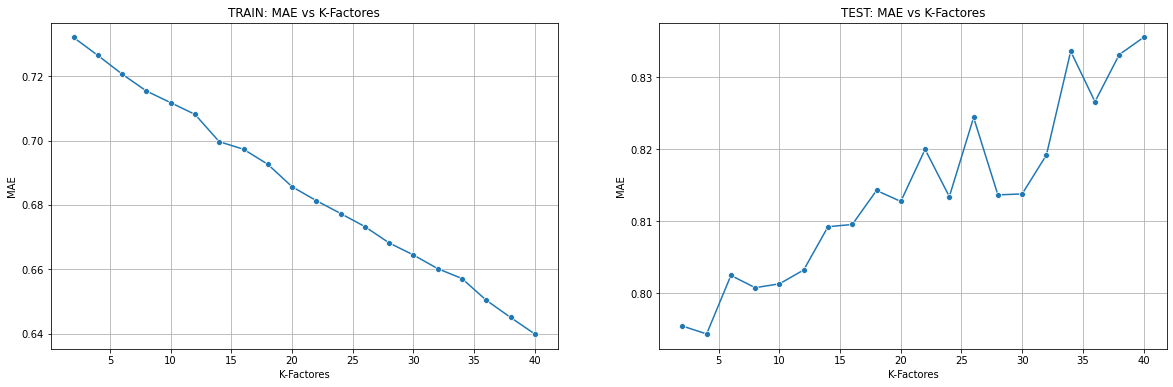

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.subplots(figsize = (20, 6))
# Pintamos el MAE con los datos de Entrenamiento
plt.subplot(1, 2, 1)
plt.title('TRAIN: MAE vs K-Factores')
plt.grid()
sns.lineplot(x="K-Factores", y="MAE", data=df_results[df_results['Train/Test']=='Train'], marker="o")

# Pintamos el MAE con los datos de Test
plt.subplot(1, 2, 2)
plt.title('TEST: MAE vs K-Factores')
plt.grid()
sns.lineplot(x="K-Factores", y="MAE", data=df_results[df_results['Train/Test']=='Test'], marker="o")

plt.show()

## Referencias

Mnih, A., & Salakhutdinov, R. R. (2008). **Probabilistic matrix factorization**. In Advances in neural information processing systems (pp. 1257-1264).

Koren, Y., Bell, R., & Volinsky, C. (2009). **Matrix factorization techniques for recommender systems**. Computer, (8), 30-37.

<hr>


*Este documento ha sido desarrollado por **Ricardo Moya**, basandose en el material creado por **Fernando Ortega**. Dpto. Sistemas Informáticos, ETSI de Sistemas Informáticos, Universidad Politécnica de Madrid.* respetando la licencia: "Atribución-NoComercial-CompartirIgual" definida por **Creative Commons Corporation**.


<img src="../imgs/CC_BY-NC-SA.png" alt="CC BY-NC">

<p style="text-align:center"><b>Atribución-NoComercial-CompartirIgual</b></p>
